In [1]:
import numpy as np

goal_state=np.arange(1,17).reshape(4,4)
def calculate_manhattan_distance(current_pos,goal_pos):
	return abs(current_pos[0]-goal_pos[0])+abs(current_pos[1]-goal_pos[1])

def find_tile_position(grid,tile):
	row,col=np.where(grid==tile)
	return row[0],col[0]

def total_manhattan_distance(current_state):
	total_manhattan_distance=0
	for num in range(1,16):
		current_pos=find_tile_position(current_state,num)
		goal_pos=find_tile_position(goal_state,num)
		total_manhattan_distance+=calculate_manhattan_distance(current_pos,goal_pos)
	return total_manhattan_distance

def is_solvable(state):
    permutation = state.flatten()
    inversions = 0
    for i in range(len(permutation)):
        for j in range(i + 1, len(permutation)):
            if permutation[i] == 0 or permutation[j] == 0:
                continue
            if permutation[i] > permutation[j]:
                inversions += 1
    num_rows = state.shape[0]
    if num_rows % 2 == 0:
        empty_row = np.where(state == 0)[0][0]
        return (inversions + empty_row) % 2 == 0
    else:
        return inversions % 2 == 0

In [2]:
import gymnasium as gym
from gymnasium.spaces import Discrete,Box,Tuple
from gymnasium.utils import seeding

class FifteenPuzzleEnv(gym.Env):
	def __init__(self,config=None):
		self.current_steps=0
		self.max_episode_steps=100
		self.action_space=Discrete(4)  # 0: left, 1: up, 2: right, 3: down
		self.grid_size=4
		self.observation_space=Tuple((Box(low=0,high=self.grid_size**2-1,shape=(self.grid_size,self.grid_size),dtype=np.int32),
									 Box(low=0,high=self.grid_size**2-1,shape=(self.grid_size,self.grid_size),dtype=np.int32),
									 Box(low=0,high=self.grid_size-1,shape=(2,),dtype=np.int32),))
		self.seed()
		self.reset()

	def seed(self,seed=None):
		self.np_random,seed=seeding.np_random(seed)
		return [seed]

	def reset(self,seed=None,options=None):
		self.state=np.arange(self.grid_size**2)
		self.np_random.shuffle(self.state)
		while not is_solvable(self.state):
			self.np_random.shuffle(self.state)
		self.current_steps=0
		self.state=self.state.reshape((self.grid_size,self.grid_size))
		self.zero_pos=np.argwhere(self.state==0)[0]
		return (self.state,self.state,self.zero_pos),{}

	def step(self,action):
		previous_state = self.state.copy()
		self.current_steps+=1
		distance_1=total_manhattan_distance(self.state)
		valid_move=self.move(action)
		d=self.is_solved() or self.current_steps>=self.max_episode_steps
		distance_2=total_manhattan_distance(self.state)
		r=-distance_2/5+np.sum(self.state==goal_state)*5
		if not valid_move:
			r-=5
		return (previous_state,self.state,self.zero_pos),r,d,False,{}

	def move(self,action):
		new_zero_pos=np.array(self.zero_pos)
		if action==0:  # left
			new_zero_pos[1]-=1
		elif action==1:  # up
			new_zero_pos[0]-=1
		elif action==2:  # right
			new_zero_pos[1]+=1
		elif action==3:  # down
			new_zero_pos[0]+=1

		if (0<=new_zero_pos[0]<self.grid_size) and (0<=new_zero_pos[1]<self.grid_size):
			self.state[self.zero_pos[0],self.zero_pos[1]],self.state[new_zero_pos[0],new_zero_pos[1]]=(
				self.state[new_zero_pos[0],new_zero_pos[1]],
				self.state[self.zero_pos[0],self.zero_pos[1]],
			)
			self.zero_pos=new_zero_pos
			return True
		else:
			return False

	def is_solved(self):
		goal_state=np.arange(1,17).reshape((self.grid_size,self.grid_size))
		goal_state[3][3]=0
		return np.array_equal(self.state,goal_state)

In [3]:
env = FifteenPuzzleEnv()
obs,_ = env.reset()

In [4]:
env.step(0)

((array([[ 9,  4, 15, 14],
         [ 2, 12,  3,  6],
         [ 7,  0, 10,  5],
         [ 1, 11,  8, 13]]),
  array([[ 9,  4, 15, 14],
         [ 2, 12,  3,  6],
         [ 0,  7, 10,  5],
         [ 1, 11,  8, 13]]),
  array([2, 0])),
 -7.6,
 False,
 False,
 {})

In [8]:
import ray
from ray import tune,air
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.callbacks import MemoryTrackingCallbacks
from ray.tune.logger import LoggerCallback
from ray.air import session
from ray.tune.registry import register_env

register_env("fp", lambda config: FifteenPuzzleEnv())


class RewardLoggerCallback(LoggerCallback):
	def __init__(self) -> None:
		self.results = []

	def log_trial_result(self, iteration: int, trial, result):
		reward = result  # assuming 'reward' is your reward key
		self.results.append(reward)

callback = RewardLoggerCallback()

stopping_criterion = {"training_iteration": 200}
ray.init(ignore_reinit_error=True, log_to_driver=False)
tuner = tune.Tuner(
	"PPO",
	param_space={
		"env": "fp",
		"framework": "torch",
		"num_gpus": 0,
		"num_workers":9,
		# "model":{
		# 	"fcnet_hiddens":[512,512],
		# 	"fcnet_activation":"relu",
		# 	"conv_filters":[[16, [3, 3], 1], [32, [3, 3], 1], [512, [3, 3], 1]],
		# }
	},
	run_config=air.RunConfig(
		stop=stopping_criterion,callbacks=[callback],
		checkpoint_config=air.CheckpointConfig(checkpoint_frequency=1),
	),
)
results = tuner.fit()
ray.shutdown()

2023-08-10 23:51:16,353	INFO worker.py:1636 -- Started a local Ray instance.
2023-08-10 23:51:17,010	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-10 23:51:17,011	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-10 23:51:17,019	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/maml/maml.py` has been deprecated. Use `rllib_contrib/maml/` instead. This will raise an error in the future!


Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_total,training_iteration,trial_id
PPO_fp_bddfa_00000,800000,"{'ObsPreprocessorConnector_ms': 0.009552240371704102, 'StateBufferConnector_ms': 0.0028672218322753906, 'ViewRequirementAgentConnector_ms': 0.05671286582946777}","{'num_env_steps_sampled': 800000, 'num_env_steps_trained': 800000, 'num_agent_steps_sampled': 800000, 'num_agent_steps_trained': 800000}",{},2023-08-11_00-07-56,True,100,{},1952.8,-364.498,-1117.4,45,8000,michaelmbp.local,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 3.22104707065449, 'cur_kl_coeff': 0.6750000000000002, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 9.768115587131952, 'policy_loss': -0.05133356688849588, 'vf_loss': 9.808852341354534, 'vf_explained_var': -0.018175522165913737, 'kl': 0.015698930684537576, 'entropy': 0.7244146464973368, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 185535.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 800000, 'num_env_steps_trained': 800000, 'num_agent_steps_sampled': 800000, 'num_agent_steps_trained': 800000}",200,127.0.0.1,800000,800000,800000,4000,832.707,800000,4000,832.707,0,9,0,0,4000,"{'cpu_util_percent': 35.63333333333333, 'ram_util_percent': 58.0}",33104,{},{},{},"{'mean_raw_obs_processing_ms': 0.17920272597667153, 'mean_inference_ms': 1.0462285750371794, 'mean_action_processing_ms': 0.0685247944294271, 'mean_env_wait_ms': 0.1518738815169, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 1952.7999999999975, 'episode_reward_min': -1117.3999999999999, 'episode_reward_mean': -364.49800000000005, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 45, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [674.0000000000001, 1472.200000000002, 139.19999999999996, -468.99999999999994, -818.4000000000005, -833.1999999999996, -329.19999999999925, 213.20000000000005, -640.8, 317.7999999999999, -205.2000000000002, -398.00000000000045, -362.79999999999956, -601.6, -741.8000000000003, -432.5999999999996, -981.3999999999997, -386.2, 295.00000000000057, -809.5999999999991, -898.5999999999998, 172.19999999999996, -595.1999999999996, 175.60000000000002, 1952.7999999999975, -676.4, -178.00000000000003, -217.79999999999984, 134.79999999999998, -830.3999999999996, -917.0000000000006, -849.3999999999996, -604.8000000000003, -424.99999999999994, -976.3999999999995, -437.59999999999974, -917.2, -348.39999999999986, -746.6, -176.80000000000004, -722.5999999999999, -311.3999999999992, -664.199999999999, -1008.8000000000002, -926.4000000000008, -746.0, -601.3999999999996, -137.60000000000005, -333.2000000000001, -41.39999999999995, 80.79999999999994, -101.19999999999995, -667.1999999999992, 313.9999999999998, -1117.3999999999999, -536.8, -779.8, -750.5999999999998, 635.8000000000004, -387.3999999999995, 185.4, -183.79999999999993, -87.20000000000005, -662.4000000000008, 359.99999999999955, -748.1999999999999, -482.1999999999993, 554.1999999999999, -81.20000000000003, -641.9999999999998, -705.0, -932.1999999999996, -867.8, -584.2000000000002, -599.5999999999997, 

2023-08-11 00:07:56,760	INFO tune.py:1111 -- Total run time: 999.74 seconds (999.65 seconds for the tuning loop).


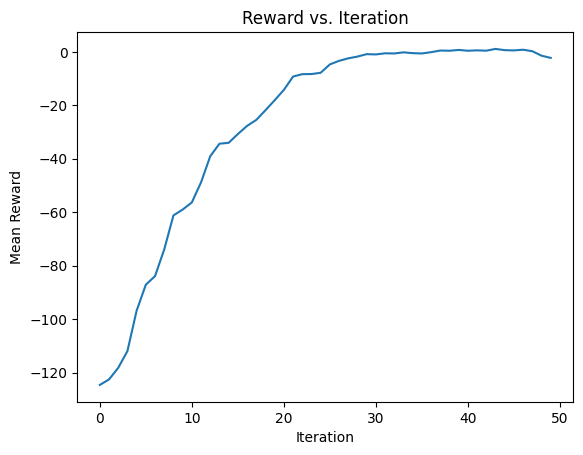

In [13]:
import matplotlib.pyplot as plt

rewards=[i["episode_reward_mean"] for i in callback.results]

plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward vs. Iteration")
plt.show()

In [14]:
results._experiment_analysis.trials

[PPO_fp_a94a6_00000]

In [15]:
# Get the best result
best_result=results.get_best_result()

# Get the best checkpoint
best_checkpoint=best_result.checkpoint

In [16]:
len(results)

1

In [10]:
best_result

Result(
  metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 3.719829128634545, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 9.117000407557335, 'policy_loss': -0.03199405585645988, 'vf_loss': 9.14532443579807, 'vf_explained_var': -0.03642877590271734, 'kl': 0.01835032038512186, 'entropy': 0.9468010985723105, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 35805.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 156000, 'num_env_steps_trained': 156000, 'num_agent_steps_sampled': 156000, 'num_agent_steps_trained': 156000}, 'sampler_results': {'episode_reward_max': -8.0, 'episode_reward_min': -444.0, 'episode_reward_mean': -118.78, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 40, 'policy_reward_min': {}, 'policy_reward_max': {}

In [11]:
from ray.rllib.algorithms.algorithm import Algorithm

register_env("fp",FifteenPuzzleEnv)
algo=Algorithm.from_checkpoint(best_checkpoint)

/home/spacefarers/.local/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/spacefarers/.local/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/spacefarers/.local/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be remove

In [12]:
from time import sleep

obs=env.reset()[0]
progression=[]
done=False

In [13]:
obs

(array([[ 9,  6,  1,  2],
        [ 3,  0,  5,  4],
        [ 7, 12,  8, 15],
        [14, 11, 10, 13]]),
 array([[ 9,  6,  1,  2],
        [ 3,  0,  5,  4],
        [ 7, 12,  8, 15],
        [14, 11, 10, 13]]))

In [14]:
from IPython.display import clear_output

while not done:
	action=algo.compute_single_action(obs)
	obs,reward,done,info,ads=env.step(action)
	print(action)
	print(reward)
	print(obs['grid'])
	sleep(0.2)
	clear_output(True)
# progression.append(obs)

3
-1


TypeError: tuple indices must be integers or slices, not str

In [ ]:

for i in progression:
	print(i)
	sleep(1)
	clear_output(wait=True)